In [95]:
import pandas as pd
import numpy  as np

import data file

In [96]:
df = pd.read_csv('data_new.csv')
df.describe()

,Label
count,329.000000
mean,0.589666
std,0.492644
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


split data

In [97]:
print("Non-cheat: ", len(df[df['Label']==0]))
print("Cheat: ", len(df[df['Label']==1]))

# diff = abs(len(df[df['Label']==0]) - len(df[df['Label']==1]))

grouped = df.groupby(df.Label)
df1 = grouped.get_group(1)
df2 = grouped.get_group(0)

df2_1 = df.iloc[:135,:]
df2_2 = df.iloc[135:194,:]

df1_train = df1.iloc[:111,:]
df2_train = df2_1.iloc[:111,:]

df1_test = df1.iloc[111:135,:]
df2_test = df2_1.iloc[111:135,:]

train = pd.concat([df1_train, df2_train])
test  = pd.concat([df1_test, df2_test, df2_2])

# shuffle data
train = train.sample(frac=1)
test  = test.sample(frac=1)

print((len(train), len(test)))

Non-cheat:  135
Cheat:  194
(222, 107)


parse data from string to numpy array

In [98]:
def parseData(series):
    final_series = []
    for ser in series:
        temp = []
        for x in "[],":
            ser = ser.replace(x, "")
        new_ser  = np.fromstring(ser, dtype=float, sep=" ")
        for i in range(0, len(new_ser), 3):
            chunk = [new_ser[i], new_ser[i + 1], new_ser[i + 2]]
            temp.append(chunk)
        final_series.append(temp)
    return np.array(final_series, dtype=object)

get the longest sequence of vector in dataset

In [99]:
max_length = 0
for lgaze in parseData(df['Left Gaze']):
    if len(lgaze) > max_length:
        max_length = len(lgaze)
        
max_length

1294

pad the dataset to the longest sequence size

In [100]:
import math

def padData(series, length):
    for idx, ser in enumerate(series):
        times = math.floor(length / len(ser))
        add = length % len(ser)
        
        temp = ser[::-1]
        for _ in range(1, times):
            series[idx] = np.append(series[idx], temp, axis=0)
            temp = temp[::-1]
        if add != 0:
            series[idx] = np.append(series[idx], temp[0:add], axis=0)
    return series

Conv1D -> AveragePooling1D -> Conv1D -> AveragePooling1D -> LSTM -> Dense

In [101]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, AveragePooling1D, LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, History

import tensorflow as tf

def init_model():
    model = Sequential()
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2))
    model.add(Conv1D(filters=12, kernel_size=3, padding="same", activation='relu', input_shape=(max_length, 12)))
    model.add(AveragePooling1D(pool_size=2))
    
    model.add(LSTM(12))
    
    adam = optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    
    model.add(Flatten())
    model.add(Dense(2, activation = 'softmax')) # We have only 2 classes: Non-cheat & Cheat
    
    model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [102]:
right_gaze_train = train["Right Gaze"]
left_gaze_train  = train["Left Gaze"]
right_head_train = train["Right HeadPose"]
left_head_train  = train["Left HeadPose"]

label_train = train['Label']

right_gaze_train, left_gaze_train, right_head_train, left_head_train = parseData(right_gaze_train), parseData(left_gaze_train), parseData(right_head_train), parseData(left_head_train)

initialize new data frame

In [103]:
left_head_train  = padData(left_head_train,  max_length)
right_head_train = padData(right_head_train, max_length)
left_gaze_train  = padData(left_gaze_train,  max_length)
right_gaze_train = padData(right_gaze_train, max_length)

In [104]:
label_train = np.array(label_train)

In [105]:
y_train = []
for i in range(len(label_train)):
    y_train.append(
        tf.convert_to_tensor(
            np.reshape(tf.keras.utils.to_categorical(label_train[i], num_classes=2), (1, 2))                 
                            )
             )
    
y_train = tf.convert_to_tensor(np.vstack(y_train), dtype=tf.float32)

In [106]:
x_train = []

for i in range(len(left_gaze_train)):
    x_train.append(tf.convert_to_tensor([
                                            np.hstack(
                                                        (left_gaze_train[i], right_gaze_train[i], left_head_train[i], right_head_train[i])
                                                     )
                                            ], dtype=tf.float32))



x_train = tf.convert_to_tensor(np.vstack(x_train), dtype=tf.float32)

print(x_train)

print(y_train)

tf.Tensor(
[[[  22.955   10.839   25.385 ...   30.359   -4.118   30.637]
  [   5.67    15.266   16.285 ...   18.896   -1.472   18.953]
  [   3.35    10.455   10.979 ...   -1.709    5.526   -5.784]
  ...
  [  -1.252   12.933  -12.994 ...    6.863    0.745    6.903]
  [  -3.019   14.169  -14.487 ...    9.237    2.032    9.458]
  [   7.474    5.718    9.41  ...    2.513    7.471    7.882]]

 [[   5.167   66.363   66.564 ...  -15.387   67.407  -69.141]
  [  -0.622   63.654  -63.657 ...  -21.034   66.766  -70.001]
  [  -4.98    59.42   -59.628 ...  -26.605   64.212  -69.505]
  ...
  [   0.544   56.081   56.084 ...  -17.186   62.639  -64.954]
  [   2.68    44.168   44.249 ...  -15.227   64.551  -66.323]
  [  -0.567   48.5    -48.503 ...  -20.76    64.987  -68.222]]

 [[  46.057   18.359   49.581 ...   38.955   -1.59    38.987]
  [  26.366   20.662   33.497 ...   27.024    1.524   27.067]
  [  -1.365   25.93   -25.966 ...    1.713    7.737    7.924]
  ...
  [ -14.193   70.864  -72.271 ...  -1

Train the model

In [107]:
model = init_model()
callbacks = [EarlyStopping(monitor='loss', patience=3), History()]
history = model.fit(x_train, y_train, epochs=100, batch_size=128, callbacks=callbacks)

Epoch 1/100


e:\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2/2 [==============================] - 3s 141ms/step - loss: 0.8551 - accuracy: 0.2477
Epoch 2/100
2/2 [==============================] - 0s 156ms/step - loss: 0.6772 - accuracy: 0.5766
Epoch 3/100
2/2 [==============================] - 0s 141ms/step - loss: 0.5992 - accuracy: 0.7613
Epoch 4/100
2/2 [==============================] - 0s 156ms/step - loss: 0.5595 - accuracy: 0.7748
Epoch 5/100
2/2 [==============================] - 0s 172ms/step - loss: 0.5233 - accuracy: 0.7928
Epoch 6/100
2/2 [==============================] - 0s 154ms/step - loss: 0.5026 - accuracy: 0.8018
Epoch 7/100
2/2 [==============================] - 0s 156ms/step - loss: 0.4836 - accuracy: 0.8153
Epoch 8/100
2/2 [==============================] - 0s 156ms/step - loss: 0.4724 - accuracy: 0.8153
Epoch 9/100
2/2 [==============================] - 0s 172ms/step - loss: 0.4476 - accuracy: 0.8333
Epoch 10/100
2/2 [==============================] - 0s 156ms/step - loss: 0.4431 - accuracy: 0.8378
Epoch 11/100
2/2 [===

In [108]:
for layer in model.layers:
    print(layer.output_shape)

(None, 1294, 12)
(None, 647, 12)
(None, 647, 12)
(None, 323, 12)
(None, 12)
(None, 12)
(None, 2)


Predict test set

In [109]:
right_gaze_test = test["Right Gaze"]
left_gaze_test  = test["Left Gaze"]
right_head_test = test["Right HeadPose"]
left_head_test  = test["Left HeadPose"]

label_test = test['Label']

right_gaze_test, left_gaze_test, right_head_test, left_head_test = parseData(right_gaze_test), parseData(left_gaze_test), parseData(right_head_test), parseData(left_head_test)

In [110]:
left_head_test  = padData(left_head_test,  max_length)
right_head_test = padData(right_head_test, max_length)
left_gaze_test  = padData(left_gaze_test,  max_length)
right_gaze_test = padData(right_gaze_test, max_length)

In [111]:
x_test = []

for i in range(len(left_gaze_test)):
    x_test.append(tf.convert_to_tensor([
                                            np.hstack(
                                                        (left_gaze_test[i], right_gaze_test[i], left_head_test[i], right_head_test[i])
                                                     )
                                            ], dtype=tf.float32))



x_test = tf.convert_to_tensor(np.vstack(x_test), dtype=tf.float32)

print(x_test)

tf.Tensor(
[[[ 6.55600e+01  1.48690e+01  6.72250e+01 ...  6.25460e+01  9.71000e+00
    6.32960e+01]
  [ 6.52610e+01  1.52220e+01  6.70130e+01 ...  6.25960e+01  8.69000e+00
    6.31960e+01]
  [ 7.14090e+01  1.62370e+01  7.32310e+01 ...  6.40220e+01  7.42400e+00
    6.44510e+01]
  ...
  [ 2.69260e+01  3.80340e+01  4.66000e+01 ...  3.36420e+01  1.25720e+01
    3.59150e+01]
  [-2.19790e+01  3.94930e+01 -4.51970e+01 ... -1.20830e+01  2.00730e+01
   -2.34300e+01]
  [-1.99320e+01  3.77660e+01 -4.27030e+01 ... -9.98400e+00  1.92070e+01
   -2.16470e+01]]

 [[ 5.94240e+01  3.38340e+01  6.83800e+01 ...  5.10690e+01  1.26530e+01
    5.26130e+01]
  [ 6.70730e+01  3.86230e+01  7.73990e+01 ...  5.35220e+01  1.51310e+01
    5.56190e+01]
  [ 6.76050e+01  3.83950e+01  7.77470e+01 ...  5.41590e+01  1.71790e+01
    5.68180e+01]
  ...
  [-3.92540e+01  2.41190e+01 -4.60720e+01 ... -3.16180e+01  1.67580e+01
   -3.57850e+01]
  [-4.62210e+01  2.05720e+01 -5.05920e+01 ... -4.34890e+01  2.00640e+01
   -4.78940e+

In [112]:
predictions = model.predict(x_test)

label_predictions = []

# convert from category to label
for prediction in predictions:
    if prediction[0] > prediction[1]:
        label_predictions.append(0)
    else: label_predictions.append(1)
    
label_predictions = np.array(label_predictions)
label_test = np.array(label_test)

print(label_predictions)
print(label_test)

# calc acc
true_count = 0
for idx, label in enumerate(label_predictions):
    if label == label_test[idx]:
        true_count += 1
        
print("Accuracy on test set: ", true_count/(len(label_test)))

4/4 [==============================] - 1s 30ms/step
[1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1]
[1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 1 1 0 0 1 1 1 0 0 1 1 0 1
 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 1]
Accuracy on test set:  0.7757009345794392


In [113]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


In [114]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

plot the loss and acc from training process

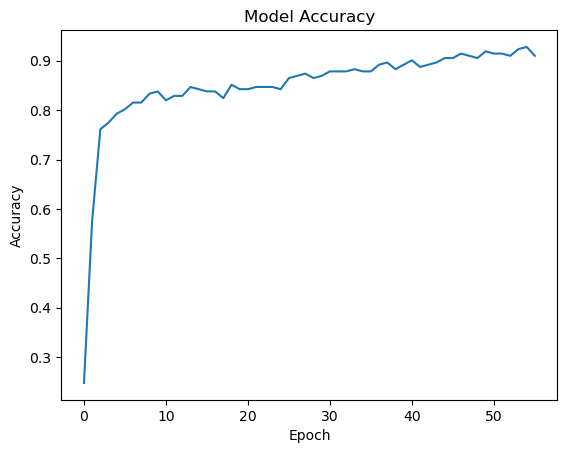

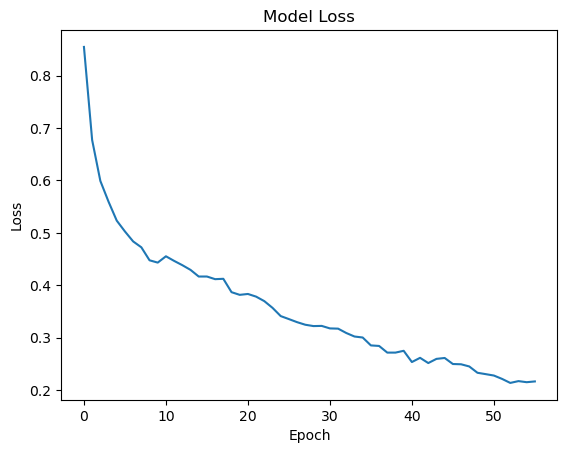

In [115]:
from matplotlib import pyplot as plt
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [116]:
model.save('GP038.keras')